In [ ]:
# a bit slow to install; only required for logo plot
#!pip install --quiet gReLU
#import gdown

In [1]:
import grelu.visualize
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import matplotlib as mpl

from os import listdir
# import isfile
from os.path import isfile

# load the matplot lib plotting style
plt.style.use('/data/davidding/dms/dms_plants/src/paper_style1.mplstyle')

# load arial.ttf font from file
import matplotlib.font_manager as font_manager
font_path = '/data/davidding/dms/dms_plants/src/Arial.ttf'
#font_prop = font_manager.FontProperties(fname=font_path)

mpl.font_manager.fontManager.addfont(font_path)
mpl.rcParams['font.family'] = 'Arial'

import importlib

import sys
sys.path.append('../src/')
import plotting as pt
import nucleotides as nt

dout = '/data/davidding/dms/plots/fig6/'

din_gb = '/data/davidding/dms/gonzalo/'

din_lr = '/data/davidding/dms/illumina_data/linreg_all/scaled_coeffs/'
din_raw = '/data/davidding/dms/illumina_data/data/clean/illumina/lrr_rcs_rescaled/'

psbs_col = '#c0bfff'
raf1_col = '#b7e6ff'
sbpase_col = '#ff8eaa'

/data/davidding/miniconda3/env2/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
'''
files = {
    "1ukIZBUMag1s-I_7lUtRqOJezevM8XPk9": "metrics_MPRA.csv.gz",
    "1Wvaov7clNPegwbEU0FBVIxubAxcnXNHI": "metrics_RNAseq.csv.gz",
    "1e3l7Zbgrfz9mOu3MdLrakJJP6wJmQun3": "preds_best_model.parquet",
    "189cc5ChrwtRtMlQROqnzTOLJAAd0wkNy": "preds_best_model_ISM.parquet",
}

for file_id, path in files.items():
    url = f"https://drive.google.com/uc?export=download&id={file_id}"
    gdown.download(url, path)
'''

Downloading...
From: https://drive.google.com/uc?export=download&id=1ukIZBUMag1s-I_7lUtRqOJezevM8XPk9
To: /content/metrics_MPRA.csv.gz
100%|██████████| 48.9k/48.9k [00:00<00:00, 36.6MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1Wvaov7clNPegwbEU0FBVIxubAxcnXNHI
To: /content/metrics_RNAseq.csv.gz
100%|██████████| 1.72k/1.72k [00:00<00:00, 3.46MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1e3l7Zbgrfz9mOu3MdLrakJJP6wJmQun3
To: /content/preds_best_model.parquet
100%|██████████| 80.2k/80.2k [00:00<00:00, 58.9MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=189cc5ChrwtRtMlQROqnzTOLJAAd0wkNy
To: /content/preds_best_model_ISM.parquet
100%|██████████| 5.84k/5.84k [00:00<00:00, 11.6MB/s]


# Model selection

In [3]:
# correlation across genes in validation split (chr9)
# only for the leaf mesophyll track
metrics_RNAseq = pd.read_csv(din_gb+"metrics_RNAseq.csv.gz", dtype={"seed": str})
metrics_RNAseq
metrics_MPRA = pd.read_csv(din_gb+"metrics_MPRA.csv.gz", dtype={"seed": str})
metrics_MPRA

,variant_type,n_variants,Pearson,Spearman,gene,epoch,seed
0,all,1127,-0.055947,-0.034061,PsbS,1,42
1,substitution,644,0.079738,0.076040,PsbS,1,42
2,insertion,209,-0.232512,-0.218805,PsbS,1,42
3,deletion,274,0.008818,-0.022637,PsbS,1,42
4,12bp_deletion,136,0.028462,0.039866,PsbS,1,42
...,...,...,...,...,...,...,...
2245,all,321,0.150251,0.140400,Raf1,30,46
2246,substitution,246,0.127372,0.090671,Raf1,30,46
2247,insertion,29,0.285108,0.439734,Raf1,30,46
2248,deletion,46,0.154368,0.175174,Raf1,30,46


In [4]:
# let's compare correlation across genes vs. variants
r_genes_col = r"$r$ across RNA-seq genes"
r_variants_col = r"$r$ across MPRA variants"
metrics_joint = (
    metrics_RNAseq.rename(columns={"pearson": r_genes_col})
    .merge(
        metrics_MPRA.query("variant_type == 'all' and gene == 'PsbS'").rename(columns={"Pearson": r_variants_col}),
        on=["seed", "epoch"],
    )
)[["seed", "epoch", r_genes_col, r_variants_col]]
metrics_joint

,seed,epoch,$r$ across RNA-seq genes,$r$ across MPRA variants
0,42,1,0.387820,-0.055947
1,43,1,0.396363,0.239139
2,44,1,0.381089,0.077761
3,45,1,0.380293,-0.052940
4,46,1,0.392429,0.061850
...,...,...,...,...
145,42,30,0.476490,0.328887
146,43,30,0.476450,0.247201
147,44,30,0.483435,0.205015
148,45,30,0.466612,0.191422


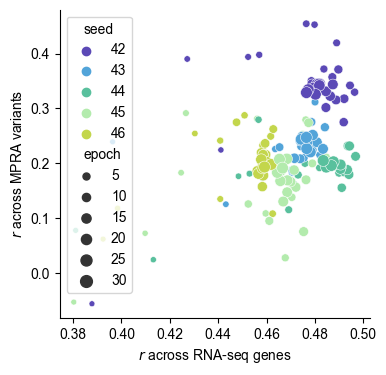

In [9]:
plt.figure(figsize=(4, 4))
g = sns.scatterplot(
    data=metrics_joint,
    x=r_genes_col,
    y=r_variants_col,
    hue="seed",
    size="epoch",
)
#sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
#sns.despine();
plt.savefig(dout + 'seeds.svg', format='svg', bbox_inches='tight')

Conclusions:
- cannot pick best model based on RNA-seq performance
- will instead pick based on a subset of variants (SNVs)

/data/davidding/miniconda3/env2/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
/data/davidding/miniconda3/env2/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
/data/davidding/miniconda3/env2/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
/data/davidding/miniconda3/env2/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `nam

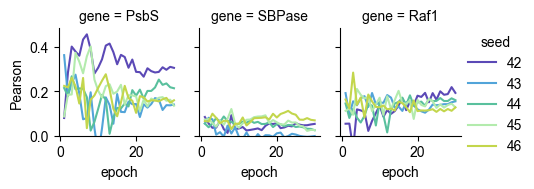

In [8]:
g = sns.relplot(
    kind="line",
    data=metrics_MPRA[(metrics_MPRA.variant_type == "substitution")],
    x="epoch",
    y="Pearson",
    hue="seed",
    col="gene",
    height=2.0,
    aspect=0.8,
)
plt.ylim(0)
sns.despine();

plt.savefig(dout + 'seeds_across_genes.svg', format='svg', bbox_inches='tight')

In [ ]:
metrics_MPRA[(metrics_MPRA.variant_type == "substitution")].sort_values("Pearson", ascending=False).iloc[0]

,151
variant_type,substitution
n_variants,644
Pearson,0.456226
Spearman,0.352196
gene,PsbS
epoch,7
seed,42


# Test set variant predictions

In [7]:
V_full = pd.read_parquet(din_gb+"preds_best_model.parquet")
V = V_full[V_full.n >= 5]



In [12]:
V['mut'] = V.ref + V.pos.astype(int).astype(str) + V.alt
V = V.rename(columns={'beta': 'old_beta'})
V

# merge in the new beta values that are rescaled for log2
s = '3C_sorghum'
df_lr = pd.read_csv(din_lr + s + '_mean_lrr_lr.csv')
df_merge = V.merge(df_lr, on='mut', how='left')
df_merge

df_merge.mut_type.value_counts()

,old_beta,pval,n,ref,pos,alt,mut_type,ref2,pred_lfc,mut
6,1.562321,7.316581e-30,5.0,A,-101.0,__,deletion,A,-0.40625,A-101__
14,1.372471,9.258762e-03,9.0,I,-223.0,A,insertion,T,-0.06250,I-223A
27,1.011442,6.721697e-28,10.0,T,-34.0,__,deletion,T,-0.12500,T-34__
32,0.917913,1.505149e-09,6.0,C,-33.0,_,deletion,C,-0.06250,C-33_
43,0.764722,4.726911e-11,5.0,I,-102.0,AAAAACAA,insertion,A,-0.71875,I-102AAAAACAA
...,...,...,...,...,...,...,...,...,...,...
2815,-0.907717,2.384073e-20,8.0,C,-162.0,__,deletion,C,-1.93750,C-162__
2816,-0.908355,5.772749e-17,6.0,C,-173.0,____________,deletion,C,-1.96875,C-173____________
2818,-0.919789,2.541083e-28,14.0,G,-174.0,____________,deletion,G,-2.03125,G-174____________
2821,-0.932932,1.792698e-12,6.0,I,-145.0,CAGAAAAAAAAAAGA,insertion,C,-1.06250,I-145CAGAAAAAAAAAAGA


scatter


/data/davidding/dms/dms_plants/04_gonzalo/../src/plotting.py:155: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


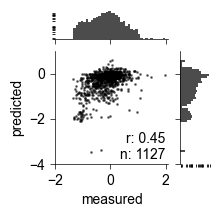

scatter


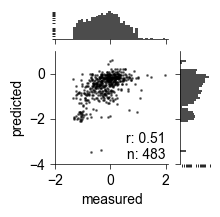

/tmp/ipykernel_266366/3453646830.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data/davidding/dms/dms_plants/04_gonzalo/../src/plotting.py:155: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


scatter


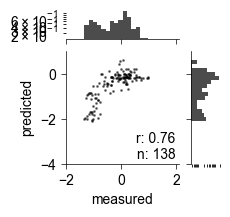

scatter


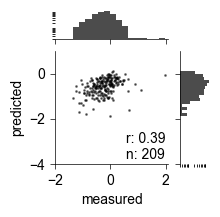

In [15]:
importlib.reload(pt)
df_plot = df_merge
pt.scatter_with_marginals(df_plot.beta, df_plot.pred_lfc, 
                          fig_size=(2,2), 
                          xlabel='measured',
                          ylabel='predicted',
                          xlim = [-2,2.1], ylim = [-4,1],
                          s=1,
                          save_path=dout + 'scatter_pred_vs_beta_all.png')

df_plot = df_merge.loc[df_merge.mut_type != 'substitution']
pt.scatter_with_marginals(df_plot.beta, df_plot.pred_lfc, 
                          fig_size=(2,2), 
                          xlabel='measured',
                          ylabel='predicted',
                          s=1,
                          xlim = [-2,2.1], ylim = [-4,1],
                          save_path=dout + 'scatter_pred_vs_beta_all_no_subs.png')

df_plot = df_merge.loc[df_merge.mut.str.contains('_')]
df_plot['len_del'] = df_plot.alt.str.len()
df_plot = df_plot.loc[(df_plot.len_del >= 10) & (df_plot.len_del <= 15)]
pt.scatter_with_marginals(df_plot.beta, df_plot.pred_lfc, 
                          fig_size=(2,2), 
                          xlabel='measured',
                          ylabel='predicted',
                          s=1,
                          n_bins=15,
                          xlim = [-2,2.1], ylim = [-4,1],
                          save_path=dout + 'scatter_pred_vs_beta_del10_to_del15.png')


df_plot = df_merge.loc[df_merge.mut_type == 'insertion']
pt.scatter_with_marginals(df_plot.beta, df_plot.pred_lfc, 
                          fig_size=(2,2), 
                          n_bins=15,
                          s=1,
                          xlabel='measured',
                          ylabel='predicted',
                          xlim = [-2,2.1], ylim = [-4,1],

                          save_path=dout + 'scatter_pred_vs_beta_insertion.png')

In [12]:
def plot_comparison(V):
    plt.figure(figsize=(2, 2))
    g = sns.scatterplot(
        data=V,
        x="beta",
        y="pred_lfc",
    )
    pearson = pearsonr(V["beta"], V["pred_lfc"])
    spearman = spearmanr(V["beta"], V["pred_lfc"])
    print(pearson, spearman)
    pearson_sig = "sig" if pearson[1] < 0.05 else "non-sig"
    spearman_sig = "sig" if spearman[1] < 0.05 else "non-sig"
    plt.title(f"Pearson: {pearson[0]:.2f} ({pearson_sig})\nSpearman: {spearman[0]:.2f} ({spearman_sig})")
    sns.despine();

# logo plot

In [16]:
# ISM
V_ISM = pd.read_parquet(din_gb + "preds_best_model_ISM.parquet")
V_ISM

,chrom,pos,ref,alt,pred_lfc
0,chromosome_3,-255.0,G,A,0.0000
1,chromosome_3,-255.0,G,C,0.0000
2,chromosome_3,-255.0,G,T,-0.0625
3,chromosome_3,-254.0,G,A,0.0000
4,chromosome_3,-254.0,G,C,-0.0625
...,...,...,...,...,...
760,chromosome_3,-2.0,G,C,0.0000
761,chromosome_3,-2.0,G,T,-0.0625
762,chromosome_3,-1.0,T,A,0.0000
763,chromosome_3,-1.0,T,C,0.0625


In [17]:
V_ISM = V_ISM.merge(df_merge[["pos", "ref", "alt", "beta"]], on=["pos", "ref", "alt"], how="left")
V_ISM

,chrom,pos,ref,alt,pred_lfc,beta
0,chromosome_3,-255.0,G,A,0.0000,0.189285
1,chromosome_3,-255.0,G,C,0.0000,0.116115
2,chromosome_3,-255.0,G,T,-0.0625,-0.091317
3,chromosome_3,-254.0,G,A,0.0000,0.160867
4,chromosome_3,-254.0,G,C,-0.0625,-0.120408
...,...,...,...,...,...,...
760,chromosome_3,-2.0,G,C,0.0000,-0.083302
761,chromosome_3,-2.0,G,T,-0.0625,-0.007916
762,chromosome_3,-1.0,T,A,0.0000,0.425981
763,chromosome_3,-1.0,T,C,0.0625,0.181660


In [18]:
V_ISM.isna().sum()

chrom         0
pos           0
ref           0
alt           0
pred_lfc      0
beta        121
dtype: int64

In [19]:
# a few SNVs were not assayed, we will assign them a beta of 0 for purposes of the logo plot
V_ISM.beta = V_ISM.beta.fillna(0)

In [27]:
def logo_plot(V, col, save_path=None, tickdilution=20):
    df = V.pivot(index="alt", columns="pos", values=col)
    assert df.columns.is_monotonic_increasing
    df.columns = V.drop_duplicates("pos").ref
    min_pos, max_pos = V.pos.min(), V.pos.max()
    g = grelu.visualize.plot_ISM(
        df,
        method="logo",
        figsize=(6, 1),
    )
    
    g.ax.spines['left'].set_visible(True)
    g.ax.spines['left'].set_linewidth(0.5)
    g.ax.set_xticklabels(
        [
            str(int(l.get_text()) + int(min_pos)) if int(l.get_text())%tickdilution==0 else ''
            for l in g.ax.get_xticklabels()
        ],
        rotation=0, fontsize=8
    )
    g.ax.tick_params(axis='x', which='major', width=0.5)
    g.ax.set_yticks([0,0.5]) 
    g.ax.set_yticklabels([0,0.5])
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path + '.svg', format='svg', dpi=300)
    plt.show()
        

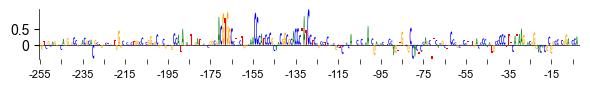

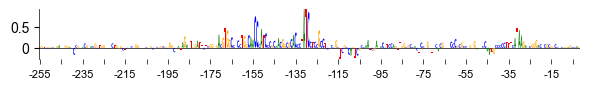

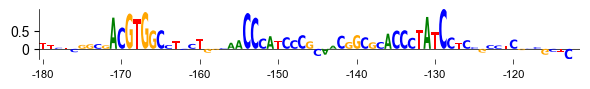

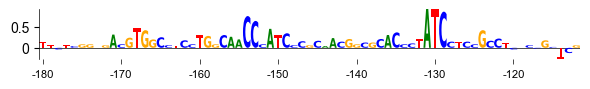

In [28]:
df_plot = V_ISM
logo_plot(df_plot, "beta", save_path=dout + 'logo_beta_measured_all')
logo_plot(df_plot, "pred_lfc", save_path=dout + 'logo_pred_pred_all')

df_plot = V_ISM.loc[(V_ISM.pos.astype(int) > -181) & (V_ISM.pos.astype(int) < -110)]
logo_plot(df_plot, "beta", save_path=dout + 'logo_beta_measured_zoom', tickdilution=5)
logo_plot(df_plot, "pred_lfc", save_path=dout + 'logo_pred_pred_zoom', tickdilution=5)